# BOUNTY PROBLEMS 
Carlos Ramon Escandell

### Bounty problem 4

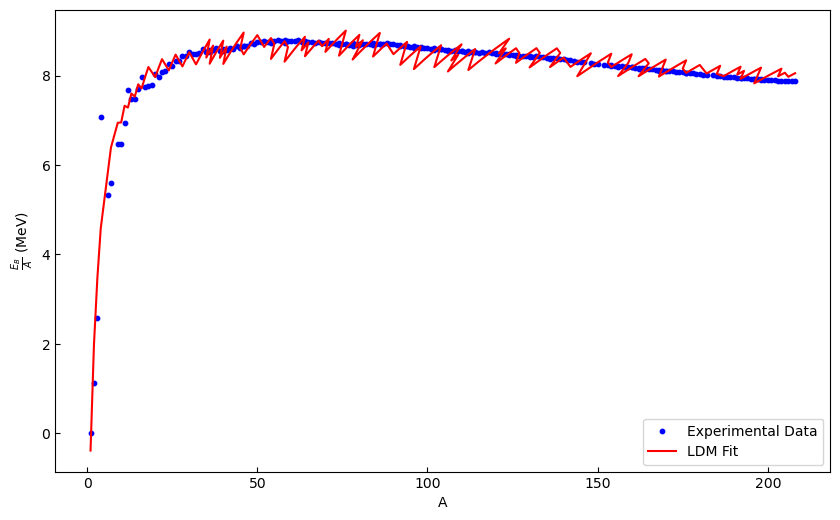

Fitted Liquid Drop Model Parameters:
a_v = 16.074045 MeV
a_s = 17.769354 MeV
a_c = 0.942769 MeV
a_a = -1.303203 MeV

Uncertainties in Parameters:
σ(a_v) = 0.233173 MeV
σ(a_s) = 0.480007 MeV
σ(a_c) = 0.033754 MeV
σ(a_a) = 0.371876 MeV


In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Function to compute binding energy using the Liquid Drop Model function
def liquid_drop_model(inputs, a_v, a_s, a_c, a_a):
    """
    Liquid Drop Model that takes both A and Z as inputs.
    Parameters:
        inputs : tuple containing (A, Z).
        a_v    : Volume energy coefficient.
        a_s    : Surface energy coefficient.
        a_c    : Coulomb energy coefficient.
        a_a    : Asymmetry energy coefficient.
    Returns:
        Binding energy per nucleon (E_b / A).
    """
    A, Z = inputs
    return (a_v
            - a_s * A ** (-1/3)
            - a_c * Z * (Z - 1) * A ** (-4/3)
            - a_a * ((A - 2 * Z) ** 2)/(A ** 2))

# Load the dataset
file_path = 'livechart.csv' 
df = pd.read_csv(file_path)

# Filter for stable nuclei only and extract necessary columns
df = df[df['half_life'] == 'STABLE']  # Filter for stable isotopes
df = df[['z', 'n', 'binding']].dropna()  # Keep relevant columns and drop NaNs

# Convert columns to numeric
df['z'] = df['z'].astype(int)  # Number of protons
df['n'] = df['n'].astype(int)  # Number of neutrons
df['binding'] = pd.to_numeric(df['binding'], errors='coerce')  # Binding energy in keV

# Compute the mass number A
df['A'] = df['z'] + df['n']

# Compute the binding energy per nucleon in MeV
df['binding_energy_per_nucleon'] = df['binding'] / 1000 

# Prepare inputs and target values
A = df['A'].values
Z = df['z'].values
binding_per_nucleon = df['binding_energy_per_nucleon'].values
inputs = (A, Z)  # Combine A and Z for the fitting process

# Initial guesses for the parameters
initial_guess = [1.0, 1.0, 0.0, 20.0]  # Reasonable starting guesses for a_v, a_s, a_c, a_a

# Fit the Liquid Drop Model to the data
popt, pcov = curve_fit(
    liquid_drop_model, inputs, binding_per_nucleon,
    p0=initial_guess,
    bounds=(-5, np.inf),  # Constrain parameters to non-negative values
    maxfev=100000 # Increase the number of iterations for convergence
)

# Extract the fitted parameters
a_v, a_s, a_c, a_a = popt

# Generate model predictions
ldm_fit = liquid_drop_model(inputs, *popt)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(A, binding_per_nucleon, color='blue', s=10, label='Experimental Data')
plt.plot(A, ldm_fit, color='red', label='LDM Fit')
plt.xlabel('A')
plt.ylabel(r'$\frac{E_B}{A}$ (MeV)')
#plt.title('Binding Energy per Nucleon vs Mass Number A')
plt.legend()
plt.tick_params(axis='both', direction='in')


plt.show()

# Print the fitted parameters and uncertainties
print("Fitted Liquid Drop Model Parameters:")
print(f"a_v = {a_v:.6f} MeV")
print(f"a_s = {a_s:.6f} MeV")
print(f"a_c = {a_c:.6f} MeV")
print(f"a_a = {a_a:.6f} MeV")

# Compute and print parameter uncertainties
parameter_uncertainties = np.sqrt(np.diag(pcov))
print("\nUncertainties in Parameters:")
print(f"σ(a_v) = {parameter_uncertainties[0]:.6f} MeV")
print(f"σ(a_s) = {parameter_uncertainties[1]:.6f} MeV")
print(f"σ(a_c) = {parameter_uncertainties[2]:.6f} MeV")
print(f"σ(a_a) = {parameter_uncertainties[3]:.6f} MeV")

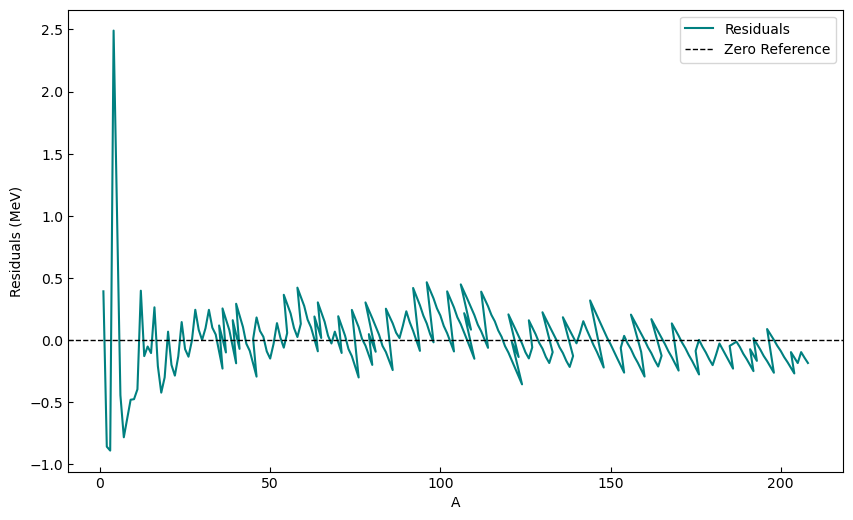

In [252]:
# Define previously fitted parameters
a_v, a_s, a_c, a_a = 16.074045, 17.769354, 0.942769, -1.303203

# Generate model predictions
ldm_fit = liquid_drop_model(inputs, a_v, a_s, a_c, a_a)

# Compute residuals
residuals = binding_per_nucleon - ldm_fit

# Plot residuals as a line
plt.figure(figsize=(10, 6))
plt.plot(A, residuals, color='teal', linewidth=1.5, label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Reference')  # Reference line at 0
plt.xlabel('A')
plt.ylabel('Residuals (MeV)')
plt.legend()
plt.tick_params(axis='both', direction='in')
#plt.grid(alpha=0.5, linestyle='--')

plt.show()

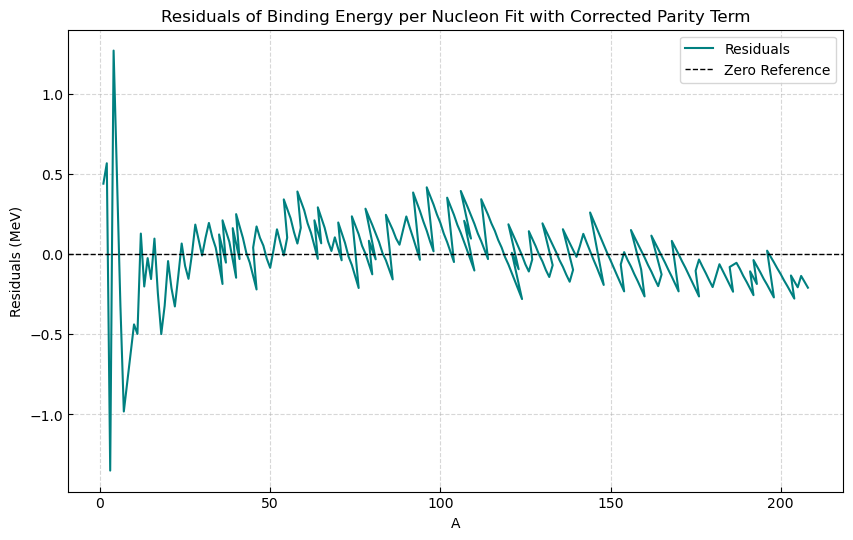

Fitted Liquid Drop Model Parameters with Parity Term:
a_v = 15.093701 MeV
a_s = 15.571371 MeV
a_c = 0.815032 MeV
a_a = -0.037073 MeV
a_p = 6.195242 MeV

Uncertainties in Parameters:
σ(a_v) = 0.227204 MeV
σ(a_s) = 0.477178 MeV
σ(a_c) = 0.032198 MeV
σ(a_a) = 0.348402 MeV
σ(a_p) = 0.672597 MeV


In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Corrected Liquid Drop Model with parity term
def liquid_drop_model_with_parity(inputs, a_v, a_s, a_c, a_a, a_p):
    A, Z = inputs
    N = A - Z  # Number of neutrons

    # Compute pairing term (δ)
    delta = np.where((Z % 2 == 0) & (N % 2 == 0), 1,
                     np.where(A % 2 != 0, 0,
                     np.where((Z % 2 != 0) & (N % 2 != 0), -1, 0)))

    # Total binding energy
    binding_energy = (
        a_v * A
        - a_s * A ** (2 / 3)
        - a_c * Z * (Z - 1) / A ** (1 / 3)  # Fixed Coulomb term
        - a_a * (A - 2 * Z) ** 2 / A
        + a_p * delta / A ** (1 / 2)        # Fixed parity term
    )

    # Binding energy per nucleon
    binding_energy_per_nucleon = binding_energy / A

    return binding_energy_per_nucleon

# Reload the dataset
file_path = 'livechart.csv'  # Update with the correct file path
df = pd.read_csv(file_path)

# Filter for stable nuclei only
df = df[df['half_life'] == 'STABLE']
df = df[['z', 'n', 'binding']].dropna()

# Ensure data types are integers for Z, N, and A
df['z'] = df['z'].astype(int)
df['n'] = df['n'].astype(int)
df['binding'] = pd.to_numeric(df['binding'], errors='coerce')
df['A'] = df['z'] + df['n']

# Compute the binding energy per nucleon in MeV
df['binding_energy_per_nucleon'] = df['binding'] / 1000

# Prepare inputs for curve fitting
A = df['A'].values
Z = df['z'].values
binding_per_nucleon = df['binding_energy_per_nucleon'].values
inputs = (A, Z)

# Initial guesses for the parameters
initial_guess = [15.5, 17.8, 0.7, 23.0, 12.0]  # Adjusted initial guesses

# Perform the fit
popt, pcov = curve_fit(
    liquid_drop_model_with_parity, inputs, binding_per_nucleon,
    p0=initial_guess,
    bounds=(-np.inf, np.inf),
    maxfev=100000
)

# Extract fitted parameters
a_v, a_s, a_c, a_a, a_p = popt

# Generate predictions and residuals
ldm_fit = liquid_drop_model_with_parity(inputs, *popt)
residuals = binding_per_nucleon - ldm_fit

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(A, residuals, color='teal', linewidth=1.5, label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Reference')
plt.xlabel('A')
plt.ylabel('Residuals (MeV)')
plt.title('Residuals of Binding Energy per Nucleon Fit with Corrected Parity Term')
plt.legend()
plt.grid(alpha=0.5, linestyle='--')
plt.tick_params(axis='both', direction='in')
plt.show()

# Print results
print("Fitted Liquid Drop Model Parameters with Parity Term:")
print(f"a_v = {a_v:.6f} MeV")
print(f"a_s = {a_s:.6f} MeV")
print(f"a_c = {a_c:.6f} MeV")
print(f"a_a = {a_a:.6f} MeV")
print(f"a_p = {a_p:.6f} MeV")

# Print uncertainties
parameter_uncertainties = np.sqrt(np.diag(pcov))
print("\nUncertainties in Parameters:")
print(f"σ(a_v) = {parameter_uncertainties[0]:.6f} MeV")
print(f"σ(a_s) = {parameter_uncertainties[1]:.6f} MeV")
print(f"σ(a_c) = {parameter_uncertainties[2]:.6f} MeV")
print(f"σ(a_a) = {parameter_uncertainties[3]:.6f} MeV")
print(f"σ(a_p) = {parameter_uncertainties[4]:.6f} MeV")


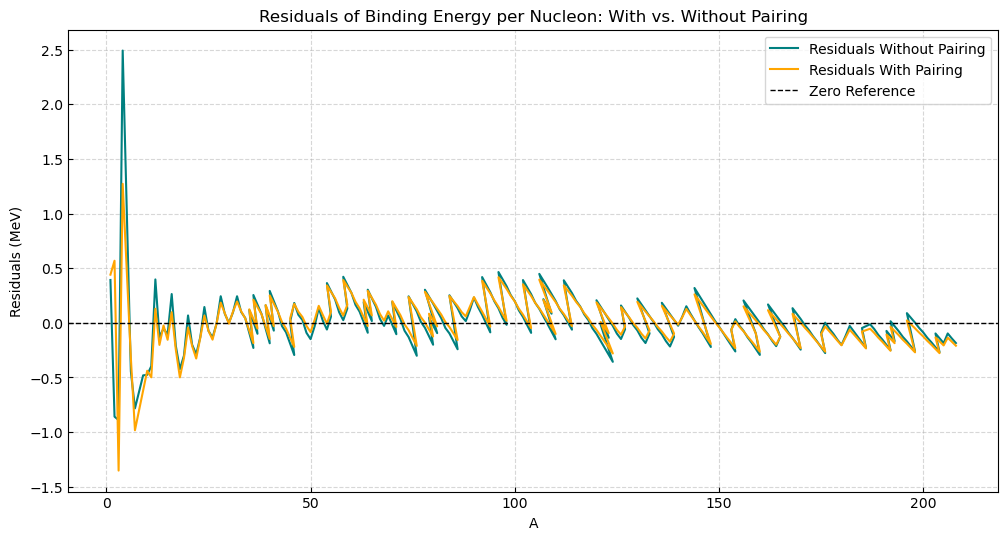

In [254]:

# Define parameters without pairing
params_without_pairing = [16.074045, 17.769354, 0.942769, -1.303203]

# Define parameters with pairing
params_with_pairing = [15.093701, 15.571371, 0.815032, -0.037073, 6.195242]


# Generate predictions without pairing
ldm_fit_no_pairing = liquid_drop_model(inputs, *params_without_pairing)
residuals_no_pairing = binding_per_nucleon - ldm_fit_no_pairing

# Generate predictions with pairing
ldm_fit_with_pairing = liquid_drop_model_with_parity(inputs, *params_with_pairing)
residuals_with_pairing = binding_per_nucleon - ldm_fit_with_pairing

# Plot residuals
plt.figure(figsize=(12, 6))

# Residuals without pairing
plt.plot(A, residuals_no_pairing, color='teal', linewidth=1.5, label='Residuals Without Pairing')

# Residuals with pairing
plt.plot(A, residuals_with_pairing, color='orange', linewidth=1.5, label='Residuals With Pairing')

# Reference line
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Reference')

# Plot styling
plt.xlabel('A')
plt.ylabel('Residuals (MeV)')
plt.title('Residuals of Binding Energy per Nucleon: With vs. Without Pairing')
plt.legend()
plt.tick_params(axis='both', direction='in')
plt.grid(alpha=0.5, linestyle='--')

plt.show()

## Bounty 8

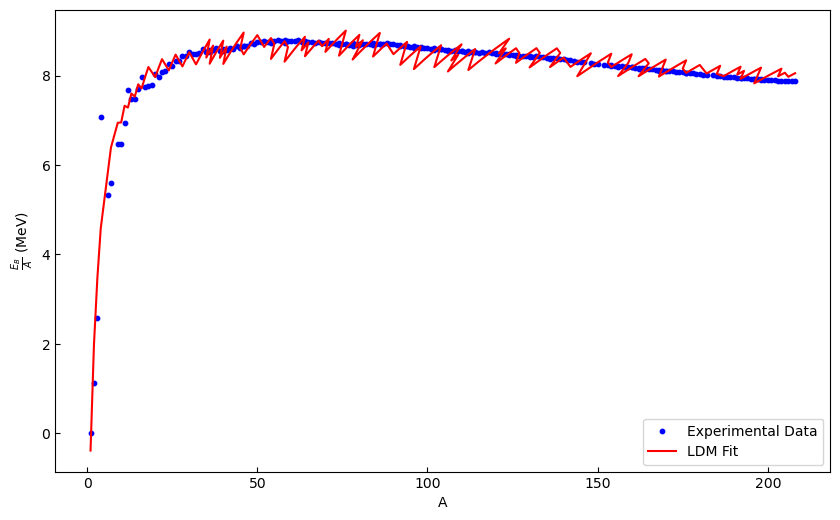

Fitted Liquid Drop Model Parameters:
a_v = 16.074045 MeV
a_s = 17.769354 MeV
a_c = 0.942769 MeV
a_a = -1.303203 MeV

Uncertainties in Parameters:
σ(a_v) = 0.233173 MeV
σ(a_s) = 0.480007 MeV
σ(a_c) = 0.033754 MeV
σ(a_a) = 0.371876 MeV


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Function to compute binding energy using the Liquid Drop Model function
def liquid_drop_model(inputs, a_v, a_s, a_c, a_a):
    """
    Liquid Drop Model that takes both A and Z as inputs.
    Parameters:
        inputs : tuple containing (A, Z).
        a_v    : Volume energy coefficient.
        a_s    : Surface energy coefficient.
        a_c    : Coulomb energy coefficient.
        a_a    : Asymmetry energy coefficient.
    Returns:
        Binding energy per nucleon (E_b / A).
    """
    A, Z = inputs
    return (a_v
            - a_s * A ** (-1/3)
            - a_c * Z * (Z - 1) * A ** (-4/3)
            - a_a * ((A - 2 * Z) ** 2)/(A ** 2))

# Load the dataset
file_path = 'livechart.csv' 
df = pd.read_csv(file_path)

# Filter for stable nuclei only and extract necessary columns
df = df[df['half_life'] == 'STABLE']  # Filter for stable isotopes
df = df[['z', 'n', 'binding']].dropna()  # Keep relevant columns and drop NaNs

# Convert columns to numeric
df['z'] = df['z'].astype(int)  # Number of protons
df['n'] = df['n'].astype(int)  # Number of neutrons
df['binding'] = pd.to_numeric(df['binding'], errors='coerce')  # Binding energy in keV

# Compute the mass number A
df['A'] = df['z'] + df['n']

# Compute the binding energy per nucleon in MeV
df['binding_energy_per_nucleon'] = df['binding'] / 1000 

# Prepare inputs and target values
A = df['A'].values
Z = df['z'].values
binding_per_nucleon = df['binding_energy_per_nucleon'].values
inputs = (A, Z)  # Combine A and Z for the fitting process

# Initial guesses for the parameters
initial_guess = [1.0, 1.0, 0.0, 20.0]  # Reasonable starting guesses for a_v, a_s, a_c, a_a

# Fit the Liquid Drop Model to the data
popt, pcov = curve_fit(
    liquid_drop_model, inputs, binding_per_nucleon,
    p0=initial_guess,
    bounds=(-5, np.inf),  # Constrain parameters to non-negative values
    maxfev=100000 # Increase the number of iterations for convergence
)

# Extract the fitted parameters
a_v, a_s, a_c, a_a = popt

# Generate model predictions
ldm_fit = liquid_drop_model(inputs, *popt)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(A, binding_per_nucleon, color='blue', s=10, label='Experimental Data')
plt.plot(A, ldm_fit, color='red', label='LDM Fit')
plt.xlabel('A')
plt.ylabel(r'$\frac{E_B}{A}$ (MeV)')
#plt.title('Binding Energy per Nucleon vs Mass Number A')
plt.legend()
plt.tick_params(axis='both', direction='in')


plt.show()

# Print the fitted parameters and uncertainties
print("Fitted Liquid Drop Model Parameters:")
print(f"a_v = {a_v:.6f} MeV")
print(f"a_s = {a_s:.6f} MeV")
print(f"a_c = {a_c:.6f} MeV")
print(f"a_a = {a_a:.6f} MeV")

# Compute and print parameter uncertainties
parameter_uncertainties = np.sqrt(np.diag(pcov))
print("\nUncertainties in Parameters:")
print(f"σ(a_v) = {parameter_uncertainties[0]:.6f} MeV")
print(f"σ(a_s) = {parameter_uncertainties[1]:.6f} MeV")
print(f"σ(a_c) = {parameter_uncertainties[2]:.6f} MeV")
print(f"σ(a_a) = {parameter_uncertainties[3]:.6f} MeV")

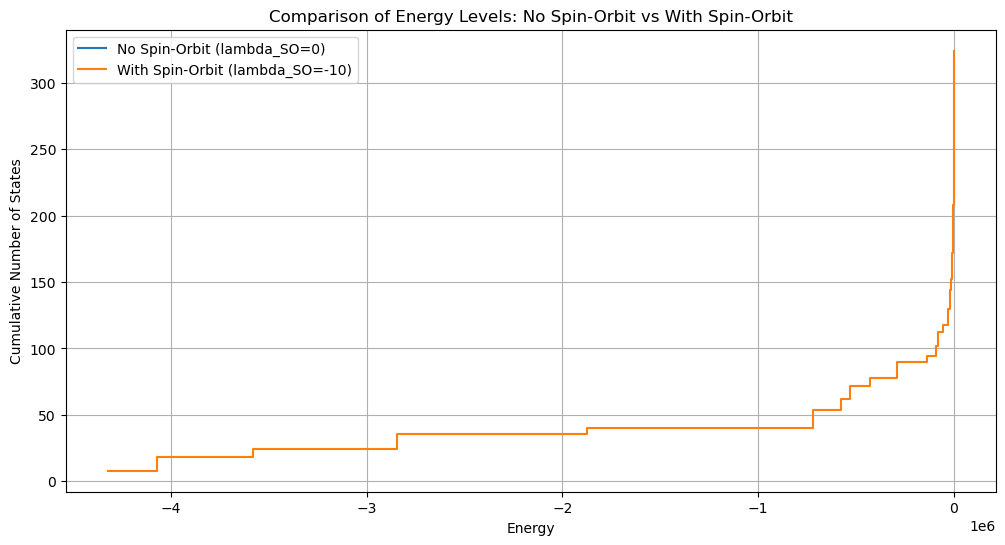

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def compute_spectrum(lambda_SO, hbar=1.0, m=1.0, R=1.0, N=1000, l_max=10):
    # Radial grid (exclude r=0 to avoid singularities)
    dr = R / (N + 1)
    r = np.linspace(dr, R - dr, N)

    energies = []
    degeneracies = []

    for l in range(0, l_max + 1):
        l_val = float(l)
        s = 0.5
        # Possible j values
        j_values = [l_val + s]
        if l_val - s >= 0:
            j_values.append(l_val - s)

        for j_val in j_values:
            # Spin-orbit term
            spin_orbit_term = j_val * (j_val + 1) - l_val * (l_val + 1) - s * (s + 1)
            # Effective potential
            V_eff = (hbar**2 / (2 * m)) * (
                l_val * (l_val + 1) / r**2 + (lambda_SO / (2 * r**2)) * spin_orbit_term
            )

            # Kinetic energy operator (finite difference)
            main_diag = -2.0 * np.ones(N) / dr**2
            off_diag = 1.0 * np.ones(N - 1) / dr**2
            T = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)

            # Hamiltonian matrix
            H = - (hbar**2 / (2 * m)) * T + np.diag(V_eff)

            # Solve the eigenvalue problem
            eigenvalues, eigenvectors = np.linalg.eigh(H)

            # Select "bound states" (negative energies)
            # Note: For an infinite well set to zero inside, normally energies are positive.
            # The original code filtered negative energies. We keep the same approach for consistency.
            bound_indices = np.where(eigenvalues < 0)[0]
            eigenvalues = eigenvalues[bound_indices]

            # Degeneracy = 2j+1
            degeneracy = int(2 * j_val + 1)
            energies.extend(eigenvalues)
            degeneracies.extend([degeneracy] * len(eigenvalues))

    # Sort energies and their degeneracies
    energies = np.array(energies)
    degeneracies = np.array(degeneracies)
    sorted_indices = np.argsort(energies)
    energies = energies[sorted_indices]
    degeneracies = degeneracies[sorted_indices]

    # Cumulative sum of degeneracies
    cumulative_degeneracies = np.cumsum(degeneracies)
    return energies, cumulative_degeneracies

# Compute spectra without spin-orbit and with spin-orbit
energies_no_so, cumul_no_so = compute_spectrum(lambda_SO=0.0)
energies_with_so, cumul_with_so = compute_spectrum(lambda_SO=-15.0)

# Plot the comparison
plt.figure(figsize=(12, 6))
plt.step(energies_no_so, cumul_no_so, where='post', label='No Spin-Orbit (lambda_SO=0)')
plt.step(energies_with_so, cumul_with_so, where='post', label='With Spin-Orbit (lambda_SO=-10)')

plt.xlabel('Energy')
plt.ylabel('Cumulative Number of States')
plt.title('Comparison of Energy Levels: No Spin-Orbit vs With Spin-Orbit')
plt.grid(True)
plt.legend()
plt.show()

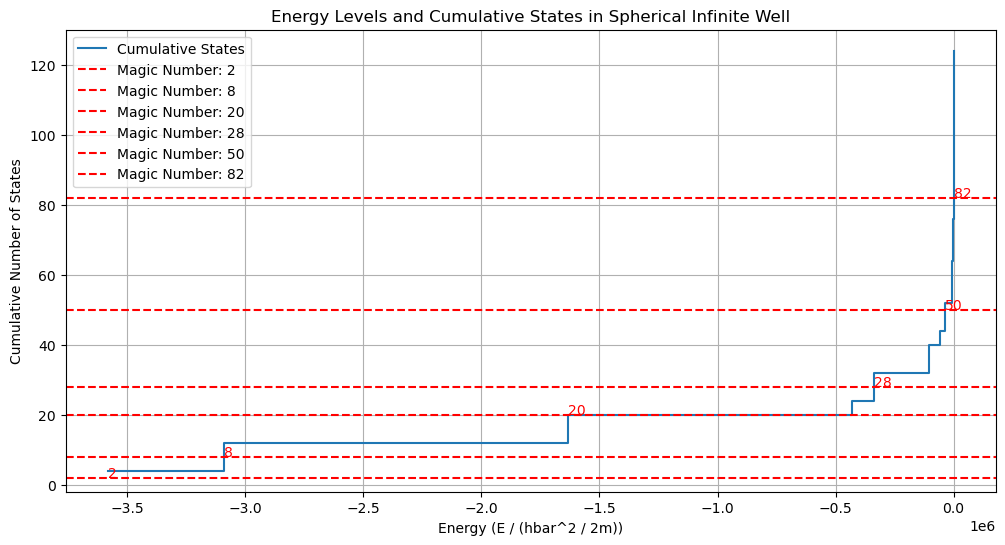

In [12]:
# Known magic numbers
magic_numbers = [2, 8, 20, 28, 50, 82, 126]

# Identify and annotate magic numbers
plt.figure(figsize=(12, 6))
plt.step(energies, cumulative_degeneracies, where='post', label="Cumulative States")
for magic in magic_numbers:
    # Find the index of the closest cumulative degeneracy
    idx = np.where(cumulative_degeneracies >= magic)[0]
    if len(idx) > 0:
        idx = idx[0]
        plt.axhline(y=magic, color='r', linestyle='--', label=f"Magic Number: {magic}")
        plt.text(energies[idx], magic, f"{magic}", color='r')

# Labels and legend
plt.xlabel('Energy (E / (hbar^2 / 2m))')
plt.ylabel('Cumulative Number of States')
plt.title('Energy Levels and Cumulative States in Spherical Infinite Well')
plt.legend()
plt.grid(True)
plt.show()